In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
from importlib import reload

In [2]:
import dataset_utils
from glob import glob

In [3]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [3]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [4]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            filtered_data.append([0,0,0,0,0])
            #  filtered_data.append([0,0,0])
            # points_removed.append(point)
    return filtered_data

In [5]:
import numpy as np
import os
import pickle
from glob import glob

def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("Processing class: {}".format(os.path.basename(folder)))
        # Store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        
        # Gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        # Process training files
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                sampled_data = []

                for arr in data:
                    # Perform background subtraction if necessary
                    bg_rm_arr = background_subtraction(background_data, arr)
                    sampled_data.append(bg_rm_arr)

                # Convert to numpy array to facilitate sampling
                sampled_data = np.array(sampled_data)
                
                # Retain original shape: (num_points, 10, 30, 5)
                np.random.seed(42)
                if sampled_data.shape[0] < num_points:
                    sampled_data = np.tile(sampled_data, (num_points // sampled_data.shape[0] + 1, 1, 1, 1))[:num_points]

                sampled_data = sampled_data[:num_points].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)

        # Process test files
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                sampled_data = []

                for arr in data:
                    # Perform background subtraction if necessary
                    bg_rm_arr = background_subtraction(background_data, arr)
                    sampled_data.append(bg_rm_arr)

                # Convert to numpy array to facilitate sampling
                sampled_data = np.array(sampled_data)

                # Retain original shape: (num_points, 10, 30, 5)
                np.random.seed(42)
                if sampled_data.shape[0] < num_points:
                    sampled_data = np.tile(sampled_data, (num_points // sampled_data.shape[0] + 1, 1, 1, 1))[:num_points]

                sampled_data = sampled_data[:num_points].astype(np.float16)
                test_points.append(sampled_data)
                test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )


In [39]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    train_points_sample.append(bg_rm_arr)
                train_points_sample = np.array(train_points_sample).reshape(-1,5)
                train_points.append(train_points_sample)
                train_labels.append(i)
               
        
        for f in test_files:
            test_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    test_points_sample.append(bg_rm_arr)
                test_points_sample = np.array(test_points_sample).reshape(-1,5)
                test_points.append(test_points_sample)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [6]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

Processing class: jumping
Processing class: picking_up
Processing class: sitting
Processing class: walking
train_points shape: (1393, 31, 10, 30, 5)
test_points shape: (349, 31, 10, 30, 5)
train_labels shape: (1393,)
test_labels shape: (349,)


In [44]:
# from sklearn.model_selection import train_test_split
# train_data, val_data, train_labels, val_labels = train_test_split(
#     train_points, train_labels, test_size=0.2, random_state=42, shuffle=True
# )

# train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
# train_dataset = tf.data.Dataset.from_tensor_slices()



In [7]:
print(CLASS_MAP)

{0: 'padded\\jumping', 1: 'padded\\picking_up', 2: 'padded\\sitting', 3: 'padded\\walking'}


In [8]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [9]:
train_size = 0.8
seed = 42
BATCH_SIZE = 32
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))

train_dataset_size = int(len(dataset) * train_size)

# dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)

dataset = dataset.shuffle(len(train_points), seed=seed)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [34]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer


In [35]:
reload(PointNET)

<module 'PointNET' from 'd:\\University\\P4P\\P4P-mmWave\\MMWave_Radar_Human_Tracking_and_Fall_detection\\PointNET.py'>

In [38]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features, NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    
    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling2D to reduce spatial dimensions
    x = layers.GlobalMaxPooling2D()(x)
    
    # Reshape for LSTM layers
    x = layers.Reshape((1, 1024))(x)  # Shape (batch_size, timesteps=1, features=1024)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer for classification
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (10, 30, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)



In [39]:

model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
model.summary()

ValueError: Incompatible input shapes: axis values 30 (at axis 2) != 5 (at axis 1). Full input shapes: (None, 10, 30, 5), (None, 5, 5)

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [74]:
INIT_TIMESTAMP = "2_10_2024_testing"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [75]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [76]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [77]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks= [ checkpoint_callback, early_stopping_callback]  
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.7984 - sparse_categorical_accuracy: 0.4625
Epoch 1: val_loss improved from inf to 4.65152, saving model to model/checkpoints/2_10_2024_testing/best.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - loss: 6.7581 - sparse_categorical_accuracy: 0.4661 - val_loss: 4.6515 - val_sparse_categorical_accuracy: 0.7488
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 4.7941 - sparse_categorical_accuracy: 0.7675
Epoch 2: val_loss improved from 4.65152 to 4.52781, saving model to model/checkpoints/2_10_2024_testing/best.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 4.7940 - sparse_categorical_accuracy: 0.7667 - val_loss: 4.5278 - val_sparse_categorical_accuracy: 0.7860
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 4.6677 - sparse_categorical_accuracy: 0.7900
Epoch 3: val_loss improved from 4.52781 to 4.38339, saving model to model/checkpoints/2_10_2024_testing/best.weights.h5
27/27 ━━━━━━━━━

In [78]:
from matplotlib import pyplot as plt


2024-10-02 15:05:21.494503: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
[[[-6.49414062e-02  1.42675781e+00  8.08593750e-01  2.50488281e-01
    3.11000000e+02]
  [ 1.21582031e-01  1.52050781e+00  8.10546875e-01  6.25976562e-01
    2.63000000e+02]
  [-1.74316406e-01  1.30273438e+00  5.29296875e-01 -2.50488281e-01
    2.51000000e+02]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]]

 [[ 8.91601562e-01  2.24609375e+00  7.27539062e-01  3.75732422e-01
    2.04000000e+02]
  [ 7.49023438e-01  2.21093750e+00  7.02148438e-01  2.50488281e-01
    2.35000000e+02]
  [ 7.70507812e-01  1.89257812e+00  2.68554688e-01  6.25976562e-01
    2.55000000e+02]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.0000

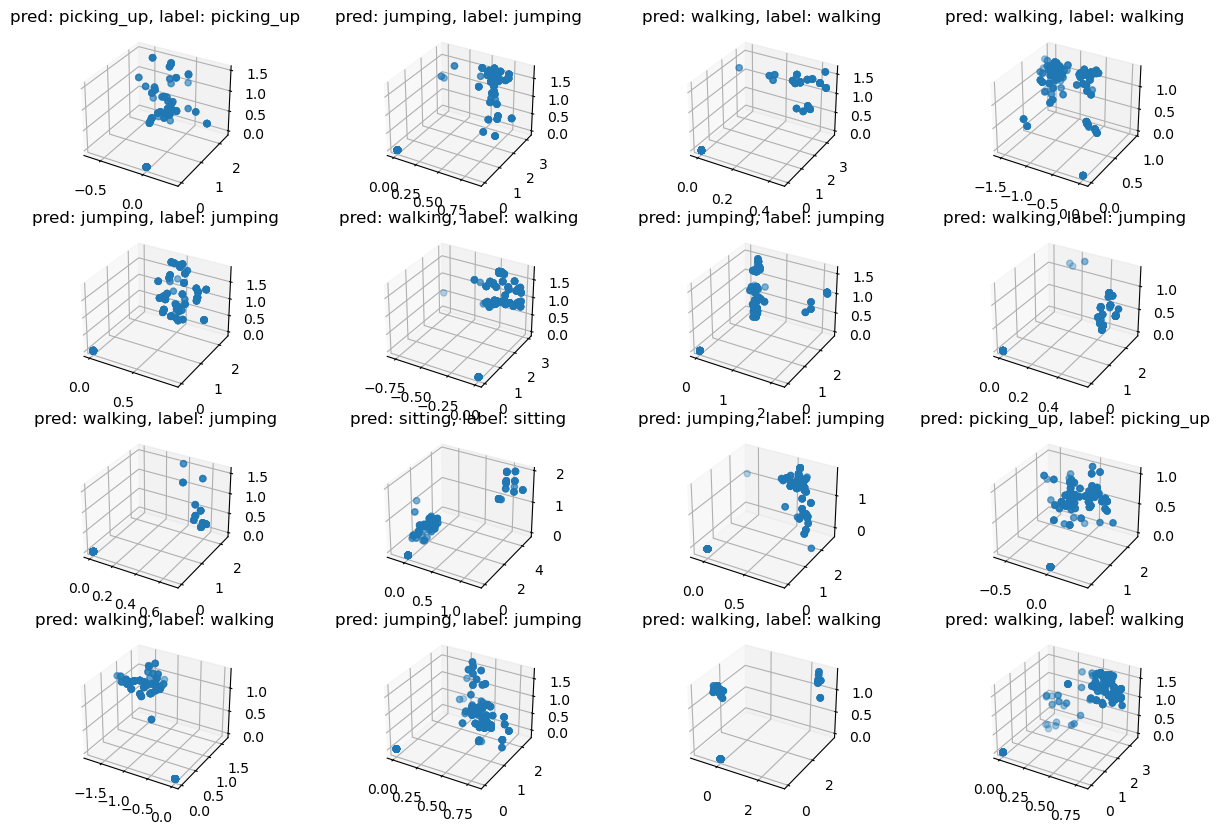

In [79]:
data = train_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
preds = preds.numpy()
labels = labels.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
num_points_to_plot = min(len(points), 16)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i]], CLASS_MAP[labels[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [81]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)
    print("argmax is", preds)
    predictions.extend(preds)

predictions = np.array(predictions)
accuracy = np.sum(predictions == test_labels) / len(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
pred is [[9.9536175e-01 1.3531897e-03 2.8439995e-03 4.4112749e-04]
 [9.9506432e-01 1.3452920e-03 2.9698620e-03 6.2052591e-04]
 [9.9551266e-01 1.3859675e-03 2.5934167e-03 5.0795090e-04]
 ...
 [1.1681455e-02 7.9759769e-03 3.0238957e-03 9.7731870e-01]
 [1.2039153e-02 7.0109596e-03 3.0917996e-03 9.7785819e-01]
 [1.3549876e-02 5.6392732e-03 4.1133184e-03 9.7669750e-01]]
(269, 300, 5)
argmax is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 2 0 0 0 1 3 0
 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 0 3 3 3 3 3 3 3 3 3]
Accuracy: 93.31%


In [82]:
BATCH_SIZE = 32
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(BATCH_SIZE)


In [83]:
predictions = []
true_labels = []

# Iterate over the test_dataset to make predictions
for batch, labels in test_dataset:
    for sample, label in zip(batch, labels):
        sample = np.expand_dims(sample, axis=0)  # Add batch dimension
        preds = model.predict(sample)  # Make a prediction
        preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
        
        predictions.extend(preds)  # Extend the predictions list
        true_labels.extend([label.numpy()])  # Append the true label (not extend)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

2024-10-02 15:06:32.699700: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [84]:
print(len(predictions))

269


In [85]:
print(len(true_labels))

269


In [86]:
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [87]:
accuracy = np.sum(predictions == true_labels) / len(true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.31%


In [88]:
print(predictions)

[2 1 2 0 2 1 2 3 0 1 2 2 2 1 2 0 0 0 2 1 3 1 0 2 3 0 0 0 0 0 0 2 1 2 2 3 1
 3 0 0 0 2 0 2 3 2 2 3 2 0 3 2 0 1 0 0 3 0 0 0 0 3 1 2 0 0 3 3 0 0 0 2 1 0
 2 3 2 0 0 0 0 3 1 0 0 1 0 3 2 0 0 0 3 0 2 2 0 2 1 0 2 2 1 2 2 1 0 2 2 2 0
 3 1 3 0 0 0 2 2 2 2 0 0 0 0 1 0 3 3 2 0 2 0 2 2 0 2 0 1 0 2 1 2 1 1 0 2 0
 3 3 1 0 0 2 0 2 3 0 2 0 1 3 0 1 2 0 2 0 2 0 3 3 0 2 3 1 0 0 2 1 2 2 2 0 0
 0 0 1 3 3 0 0 2 3 3 2 2 1 1 0 1 1 1 1 0 2 0 0 0 0 0 0 0 2 1 2 0 2 0 2 0 2
 1 0 0 2 2 0 0 0 1 0 0 0 0 2 0 0 0 2 0 1 1 0 1 2 2 0 1 0 0 2 0 2 0 0 0 2 2
 3 3 0 0 2 3 1 3 0 1]


In [89]:
print(true_labels)

[2 1 2 0 2 1 2 3 0 1 2 2 2 1 2 0 0 0 2 1 3 1 0 2 3 0 0 0 0 0 0 2 1 2 2 0 1
 2 0 0 0 2 0 2 3 2 2 3 2 0 3 2 0 1 0 0 3 0 2 0 0 3 1 2 0 0 0 3 0 0 0 2 1 0
 2 1 2 0 0 0 0 3 1 0 0 1 0 3 2 0 0 0 3 0 2 2 2 2 1 0 2 2 1 2 2 0 0 2 2 2 0
 3 1 0 0 0 0 2 2 2 2 0 0 0 0 0 0 3 1 2 2 2 0 2 2 0 2 0 1 0 2 1 2 1 1 0 2 0
 3 3 1 0 0 2 0 2 3 0 2 0 1 3 0 1 2 0 2 0 2 0 3 3 0 0 0 1 0 0 2 2 2 2 2 0 0
 0 0 1 3 3 0 0 0 3 3 2 2 1 1 0 1 1 1 1 0 2 0 0 0 0 0 0 0 2 0 2 0 2 0 2 0 2
 1 0 0 2 2 0 0 0 1 0 0 0 0 2 0 0 0 2 3 1 1 0 0 2 2 0 1 0 0 2 0 2 0 0 0 2 2
 3 3 0 0 2 3 1 3 0 1]


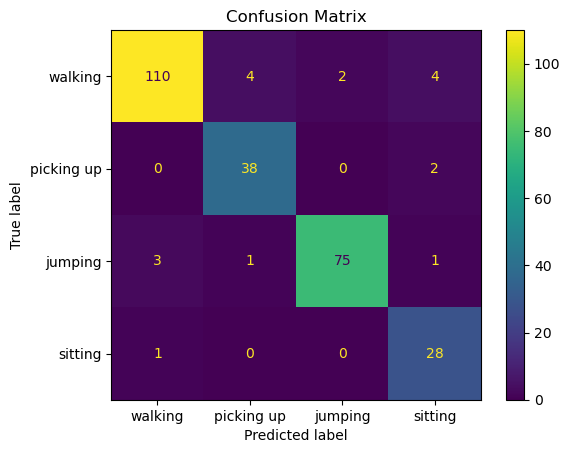

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'picking up', 'jumping', 'sitting']  # Based on your CLASS_MAP
# class_names = ['jumping','picking up','sitting','walking']
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [91]:
#reload model
reload_model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
reload_model.load_weights('./model/checkpoints/2_10_2024_testing/best.weights.h5')

In [92]:
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(1)

In [93]:
predictions = []
true_label = []

# Iterate over the test_dataset to make predictions
for batch, label in test_dataset:
    preds = reload_model.predict(batch)  # Get predictions for the current batch
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
    print("argmax is", preds)
    predictions.extend(preds)  # Extend the predictions list with the results
    true_label.extend(label)

true_label = np.array(true_label)
predictions = np.array(predictions)  # Convert predictions to a numpy array


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
pred is [[0.00377022 0.0016636  0.99319637 0.00136981]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
pred is [[0.04479595 0.8277922  0.06464714 0.06276469]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[0.00809907 0.0037542  0.98460346 0.00354323]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
pred is [[9.9526370e-01 1.3256092e-03 2.8936090e-03 5.1711971e-04]]
(1, 300, 5)
argmax is [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[0.01464851 0.00183495 0.9816289  0.0018876 ]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
pred is [[0.01763855 0.8742598  0.01725931 0.09084229]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
pred is [[0.00565736 0.00179885 0.9910272  0.00151651]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
pred is [[0.01354989 0.00563928 0.00411332 0.9766975 ]]
(1, 300, 5)
argmax is [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [94]:
accuracy = np.sum(predictions == true_label) / len(true_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.31%


In [95]:
print(predictions)

[2 1 2 0 2 1 2 3 0 1 2 2 2 1 2 0 0 0 2 1 3 1 0 2 3 0 0 0 0 0 0 2 1 2 2 3 1
 3 0 0 0 2 0 2 3 2 2 3 2 0 3 2 0 1 0 0 3 0 0 0 0 3 1 2 0 0 3 3 0 0 0 2 1 0
 2 3 2 0 0 0 0 3 1 0 0 1 0 3 2 0 0 0 3 0 2 2 0 2 1 0 2 2 1 2 2 1 0 2 2 2 0
 3 1 3 0 0 0 2 2 2 2 0 0 0 0 1 0 3 3 2 0 2 0 2 2 0 2 0 1 0 2 1 2 1 1 0 2 0
 3 3 1 0 0 2 0 2 3 0 2 0 1 3 0 1 2 0 2 0 2 0 3 3 0 2 3 1 0 0 2 1 2 2 2 0 0
 0 0 1 3 3 0 0 2 3 3 2 2 1 1 0 1 1 1 1 0 2 0 0 0 0 0 0 0 2 1 2 0 2 0 2 0 2
 1 0 0 2 2 0 0 0 1 0 0 0 0 2 0 0 0 2 0 1 1 0 1 2 2 0 1 0 0 2 0 2 0 0 0 2 2
 3 3 0 0 2 3 1 3 0 1]


In [96]:
print(true_label)

[2 1 2 0 2 1 2 3 0 1 2 2 2 1 2 0 0 0 2 1 3 1 0 2 3 0 0 0 0 0 0 2 1 2 2 0 1
 2 0 0 0 2 0 2 3 2 2 3 2 0 3 2 0 1 0 0 3 0 2 0 0 3 1 2 0 0 0 3 0 0 0 2 1 0
 2 1 2 0 0 0 0 3 1 0 0 1 0 3 2 0 0 0 3 0 2 2 2 2 1 0 2 2 1 2 2 0 0 2 2 2 0
 3 1 0 0 0 0 2 2 2 2 0 0 0 0 0 0 3 1 2 2 2 0 2 2 0 2 0 1 0 2 1 2 1 1 0 2 0
 3 3 1 0 0 2 0 2 3 0 2 0 1 3 0 1 2 0 2 0 2 0 3 3 0 0 0 1 0 0 2 2 2 2 2 0 0
 0 0 1 3 3 0 0 0 3 3 2 2 1 1 0 1 1 1 1 0 2 0 0 0 0 0 0 0 2 0 2 0 2 0 2 0 2
 1 0 0 2 2 0 0 0 1 0 0 0 0 2 0 0 0 2 3 1 1 0 0 2 2 0 1 0 0 2 0 2 0 0 0 2 2
 3 3 0 0 2 3 1 3 0 1]


In [97]:
def class_preds(DATA_DIR, model):
    files = glob(os.path.join(DATA_DIR, "[!README]*"))
    predictions = []
    for f in files:
        try:
            with open(f, 'rb') as file:
                
                data = pickle.load(file)
                test_points = []
                sample_test_points = []
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    sample_test_points.append(bg_rm_arr)
                
                data = np.concatenate(sample_test_points, axis=0)
                np.random.seed(42)
                sampled_indices = np.random.choice(data.shape[0], size=300, replace=True)
                sampled_data = data[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                # train_labels.append(i)
                # data = np.array(data).reshape(1,300,5)
                test_points = np.array(test_points)
                preds = model.predict(test_points)  # Get predictions for the current batch
                print("pred is", preds)
                print(batch.shape)
                preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
                print("argmax is", preds)
                predictions.extend(preds)  # Extend the predictions list with the results
        except Exception as e:
            print(f"Error processing file {f}: {e}")

    predictions = np.array(predictions)
    return predictions


In [104]:
# Specify your test directory
test_files = './cluster_data/padded/picking_up/test'
predictions = class_preds(test_files, reload_model)
# print(len(predictions)) 
accuracy = np.sum(predictions == 1) / len(predictions)
print(accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
pred is [[0.01509282 0.83157593 0.01937584 0.13395546]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pred is [[0.02191145 0.9086975  0.02310601 0.04628504]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
pred is [[0.02724061 0.5870459  0.03521879 0.3504947 ]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
pred is [[0.02098648 0.67939055 0.03293896 0.26668406]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[0.06488708 0.8091866  0.06623519 0.05969115]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[0.02214789 0.02478043 0.00800852 0.9450631 ]]
(1, 300, 5)
argmax is [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
pred is [[0.02060404 0.9030132  0.02267644 0.05370626]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
pred is [[0.02238663 0.47724366 0.02217777 0.4781919 ]]
(1, 300, 5)
argmax is [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pr